# Australian Grand Prix 2024

In [1]:
import numpy as np
import fastf1
import fastf1.plotting
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from fastf1.core import Laps
from timple.timedelta import strftimedelta
from fastf1.ergast import Ergast
import plotly.express as px
from plotly.io import show
fastf1.plotting.setup_mpl()
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.insert(0, "../")
from settings import CACHE_FOLDER_PATH
from utlis import *

CACHE_FOLDER_PATH: /Users/riccardoviscio1/Desktop/Projects/F1 Data Analysis/season_2024/f1_cache


In [3]:
setup_cache(CACHE_FOLDER_PATH)

In [4]:
session = fastf1.get_session(2024, 'Melbourne', 'R')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.2]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No

In [5]:
laps = session.laps

![Bahrain Circuit](https://media.formula1.com/image/upload/f_auto/q_auto/v1677244985/content/dam/fom-website/2018-redesign-assets/Circuit%20maps%2016x9/Australia_Circuit.png.transform/5col-retina/image.png)

It's already the third round and we'll take a look at the scored points to this points 

In [6]:
ergast = Ergast()
races = ergast.get_race_schedule(2024)  # Races in the year 2024
results = []

In [7]:
for rnd, race in races['raceName'].items():
    race_results = ergast.get_race_results(season=2024, round=rnd + 1)
    if race_results.content: 
        temp = race_results.content[0]


        sprint_results = ergast.get_sprint_results(season=2024, round=rnd + 1)
        if sprint_results.content and sprint_results.description['round'][0] == rnd + 1:
            temp = pd.merge(temp, sprint_results.content[0], on='driverCode', how='left')
            temp['points'] = temp['points_x'] + temp['points_y']
            temp.drop(columns=['points_x', 'points_y'], inplace=True)

        temp['round'] = rnd + 1
        temp['race'] = race.removesuffix(' Grand Prix')
        temp = temp[['round', 'race', 'driverCode', 'points']]  
        results.append(temp)


results = pd.concat(results)
races = results['race'].drop_duplicates()

pivot = results.pivot_table(index='round', columns='driverCode', values='points', aggfunc='sum').fillna(0).cumsum()
zero_row = pd.DataFrame(0, index=[0], columns=pivot.columns)
new_pivot = pd.concat([zero_row, pivot])

new_pivot.reset_index(drop = True, inplace=True)

In [8]:
races_list = races.tolist()
races_list.insert(0, "Start")
races = pd.Series(races_list)

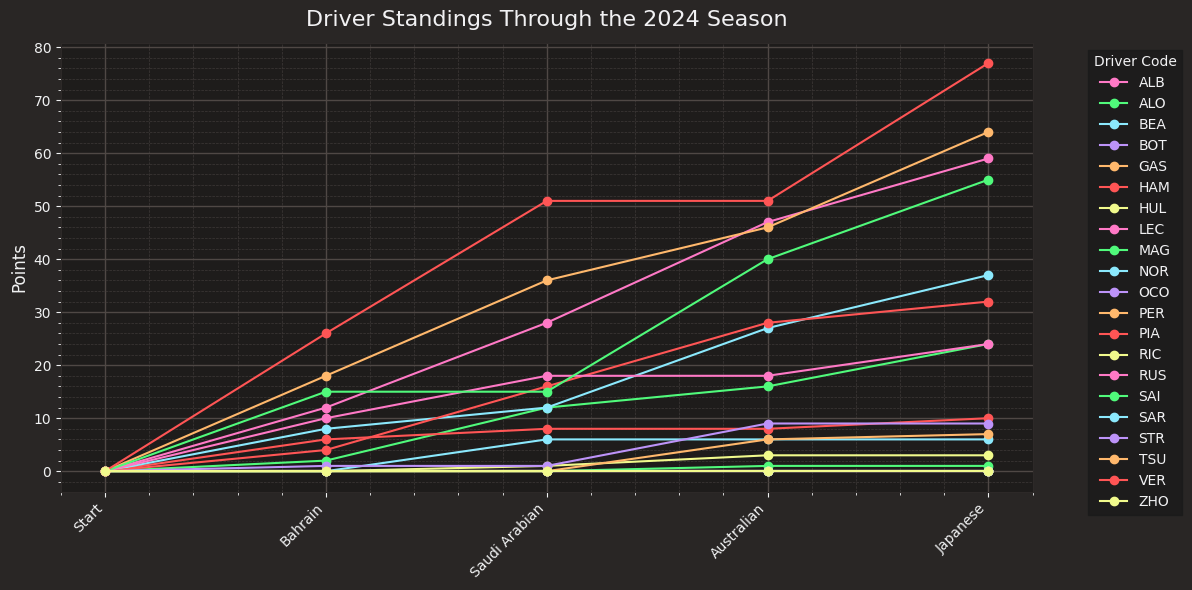

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
for column in new_pivot.columns:
    ax.plot(new_pivot.index, new_pivot[column], marker='o', label=column)

ax.set_xticks(range(len(races)))
ax.set_xticklabels(races, rotation=45, ha='right')
ax.set_ylabel('Points', fontsize=12)
ax.set_title('Driver Standings Through the 2024 Season', fontsize=16)
ax.grid(True)
ax.legend(title='Driver Code', fontsize = 10, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Bokeh example 

In [16]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, WheelZoomTool, ResetTool, Legend
from bokeh.layouts import column
from bokeh.io import show

output_notebook(hide_banner = True)

In [33]:
data = {
    'rounds': [str(x) for x in races] 
}

for column in new_pivot.columns:
    data[column] = new_pivot[column].tolist()

source = ColumnDataSource(data=data)

driver_colors = {driver: ff1.plotting.driver_color(driver) for driver in new_pivot.columns}

p = figure(x_range=data['rounds'], width=800, height=400, title='Driver Standings Through the 2024 Season',
           tools=[HoverTool(), WheelZoomTool(), ResetTool()],)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Round", "@rounds"),
    ("Driver", "$name"),  
    ("Points", "@$name")  
]

p.title.text_font = "arial"
p.xaxis.axis_label_text_font = "arial"
p.yaxis.axis_label_text_font = "arial"

p.title.text_font_size = '22pt'

for driver in new_pivot.columns:
    p.line('rounds', driver, source=source, line_width=2, color=driver_colors[driver])
    p.scatter('rounds', driver, source=source,  marker='circle', size=8, fill_color=driver_colors[driver], name=driver)

p.xaxis.axis_label = 'Round'
p.yaxis.axis_label = 'Points'
p.axis.axis_label_text_font_style = 'bold'
p.axis.major_label_orientation = "horizontal"
p.grid.grid_line_alpha = 0.3

p.legend.location = "top_left"
p.legend.title = 'Driver Code'

show(p)


# Drivers Result 

In [180]:
def plot_positions(session):
    fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
    
    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        if drv_laps.empty:
            continue  # Skip drivers with no laps

        abb = drv_laps['Driver'].iloc[0]
        color = ff1.plotting.driver_color(abb)
        ax.plot(drv_laps['LapNumber'], drv_laps['Position'], label=abb, color=color)

    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        if drv_laps.empty or np.isnan(drv_laps['Position'].iloc[0]):
            continue
        
        abb = drv_laps['Driver'].iloc[0]
        starting_position = int(drv_laps['Position'].iloc[0])
        ax.text(0.8, starting_position, f"P{starting_position}: {abb}", color='w', ha='right')

    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        if drv_laps.empty:
            continue
        
        abb = drv_laps['Driver'].iloc[0]
        final_position = drv_laps['Position'].iloc[-1]
        starting_position = int(drv_laps['Position'].iloc[0])
        if np.isnan(final_position) or np.isnan(starting_position):
            continue
        
        places_gained = int(starting_position - final_position)
        places_text = f"({'+' if places_gained > 0 else '' if places_gained == 0 else '-'}{abs(places_gained)})"
        ax.text(57, final_position, f"P{starting_position}:{abb} {places_text}", color='w', ha='left')

    ax.annotate('Starting Position', xy=(-0.14, 0.4), xycoords='axes fraction', fontsize=14, color='w', rotation=90)
    ax.annotate('Finishing Position', xy=(+1.14, 0.4), xycoords='axes fraction', fontsize=14, color='w', rotation=-90)
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([])
    ax.set_xlabel('Lap', fontsize=14)
    ax.set_xlim([1, 57])
    plt.title(f'{session}', font='Arial', fontweight='bold', fontsize=24)
    plt.tight_layout()
    plt.show()



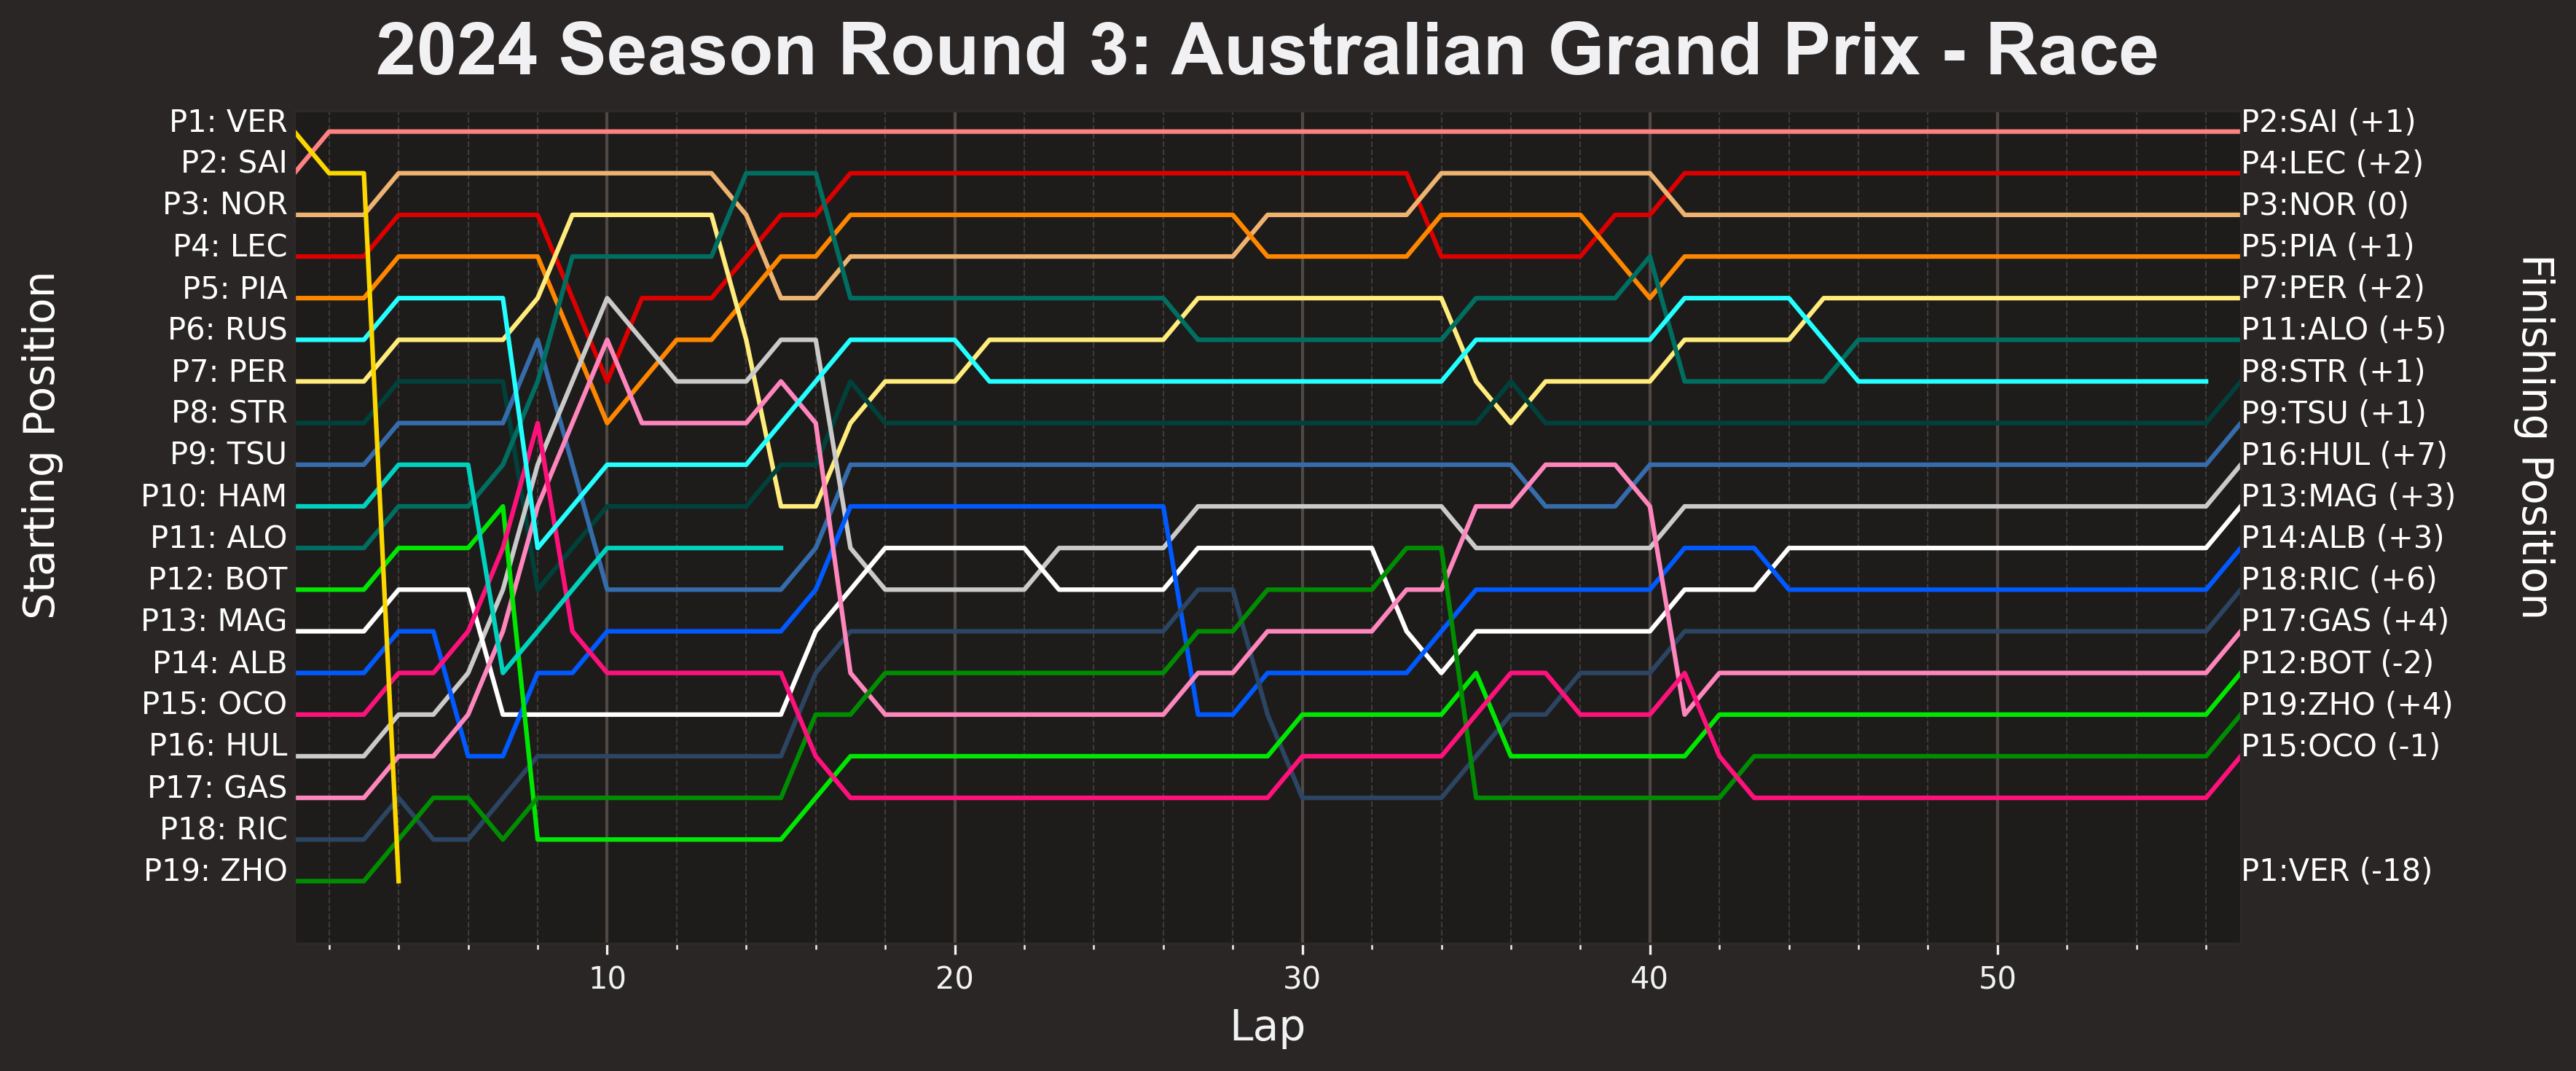

In [182]:
plot_positions(session)

# Team Mates Scatter Plot Comparison 

In [266]:
lec = session.laps.pick_driver("LEC").pick_quicklaps().reset_index()
sai = session.laps.pick_driver("SAI").pick_quicklaps().reset_index()
lec_tel = lec.pick_fastest().get_car_data().add_distance()
sai_tel = sai.pick_fastest().get_car_data().add_distance()

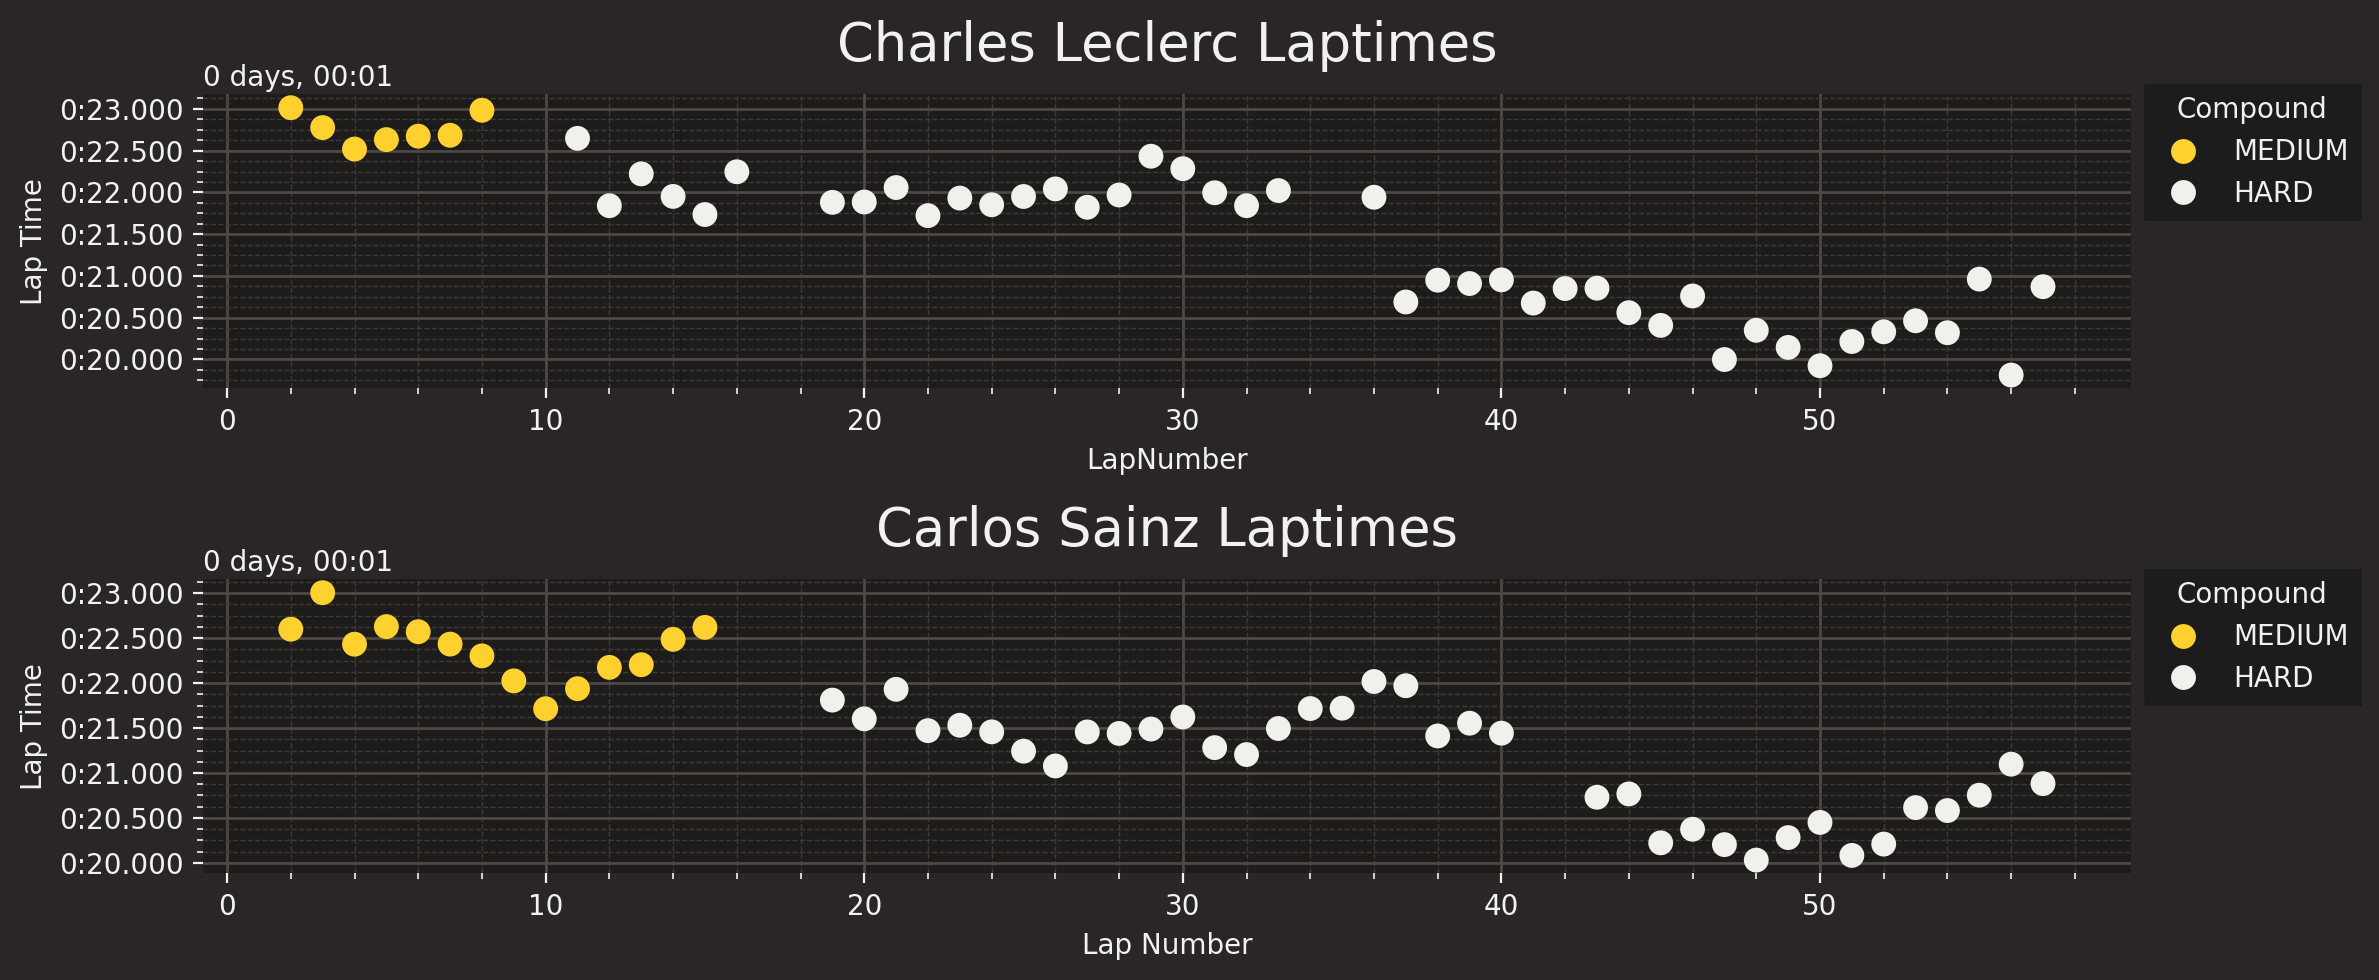

In [186]:
fig, (ax1,ax2)= plt.subplots(2,1,figsize=(12, 5), dpi = 200)
sns.scatterplot(data=lec,
                x="LapNumber",
                y="LapTime",
                ax=ax1,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                s=80,
                linewidth=0)

ax1.set_ylabel("Lap Time")
ax1.invert_yaxis()
ax1.set_title("Charles Leclerc Laptimes")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=labels, title="Compound", loc="upper left",  bbox_to_anchor=(1, 1.078))

sns.scatterplot(data=sai,
                x="LapNumber",
                y="LapTime",
                ax=ax2,
                hue="Compound",
                palette=fastf1.plotting.COMPOUND_COLORS,
                s=80,
                linewidth=0)

ax2.set_xlabel("Lap Number")
ax2.set_ylabel("Lap Time")
ax2.invert_yaxis()
ax2.set_title("Carlos Sainz Laptimes")

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=labels, title="Compound", loc="upper left",  bbox_to_anchor=(1, 1.078))

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [197]:
def plot_driver_laptimes(session, driver1, driver2):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), dpi=200)

    # Driver 1 lap times
    driver1_laps = session.laps.pick_driver(driver1).pick_quicklaps().reset_index()
    sns.scatterplot(data=driver1_laps,
                    x="LapNumber",
                    y="LapTime",
                    ax=ax1,
                    hue="Compound",
                    palette=fastf1.plotting.COMPOUND_COLORS,
                    s=80,
                    linewidth=0)
    ax1.set_ylabel("Lap Time")
    ax1.invert_yaxis()
    ax1.set_title(f"{driver1} Laptimes")
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=labels, title="Compound", loc="upper left", bbox_to_anchor=(1, 1.078))

    # Driver 2 lap times
    driver2_laps = session.laps.pick_driver(driver2).pick_quicklaps().reset_index()
    sns.scatterplot(data=driver2_laps,
                    x="LapNumber",
                    y="LapTime",
                    ax=ax2,
                    hue="Compound",
                    palette=fastf1.plotting.COMPOUND_COLORS,
                    s=80,
                    linewidth=0)
    ax2.set_xlabel("Lap Number")
    ax2.set_ylabel("Lap Time")
    ax2.invert_yaxis()
    ax2.set_title(f"{driver2} Laptimes")
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles, labels=labels, title="Compound", loc="upper left", bbox_to_anchor=(1, 1.078))

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# plot_driver_laptimes(session, 'LEC', 'SAI')


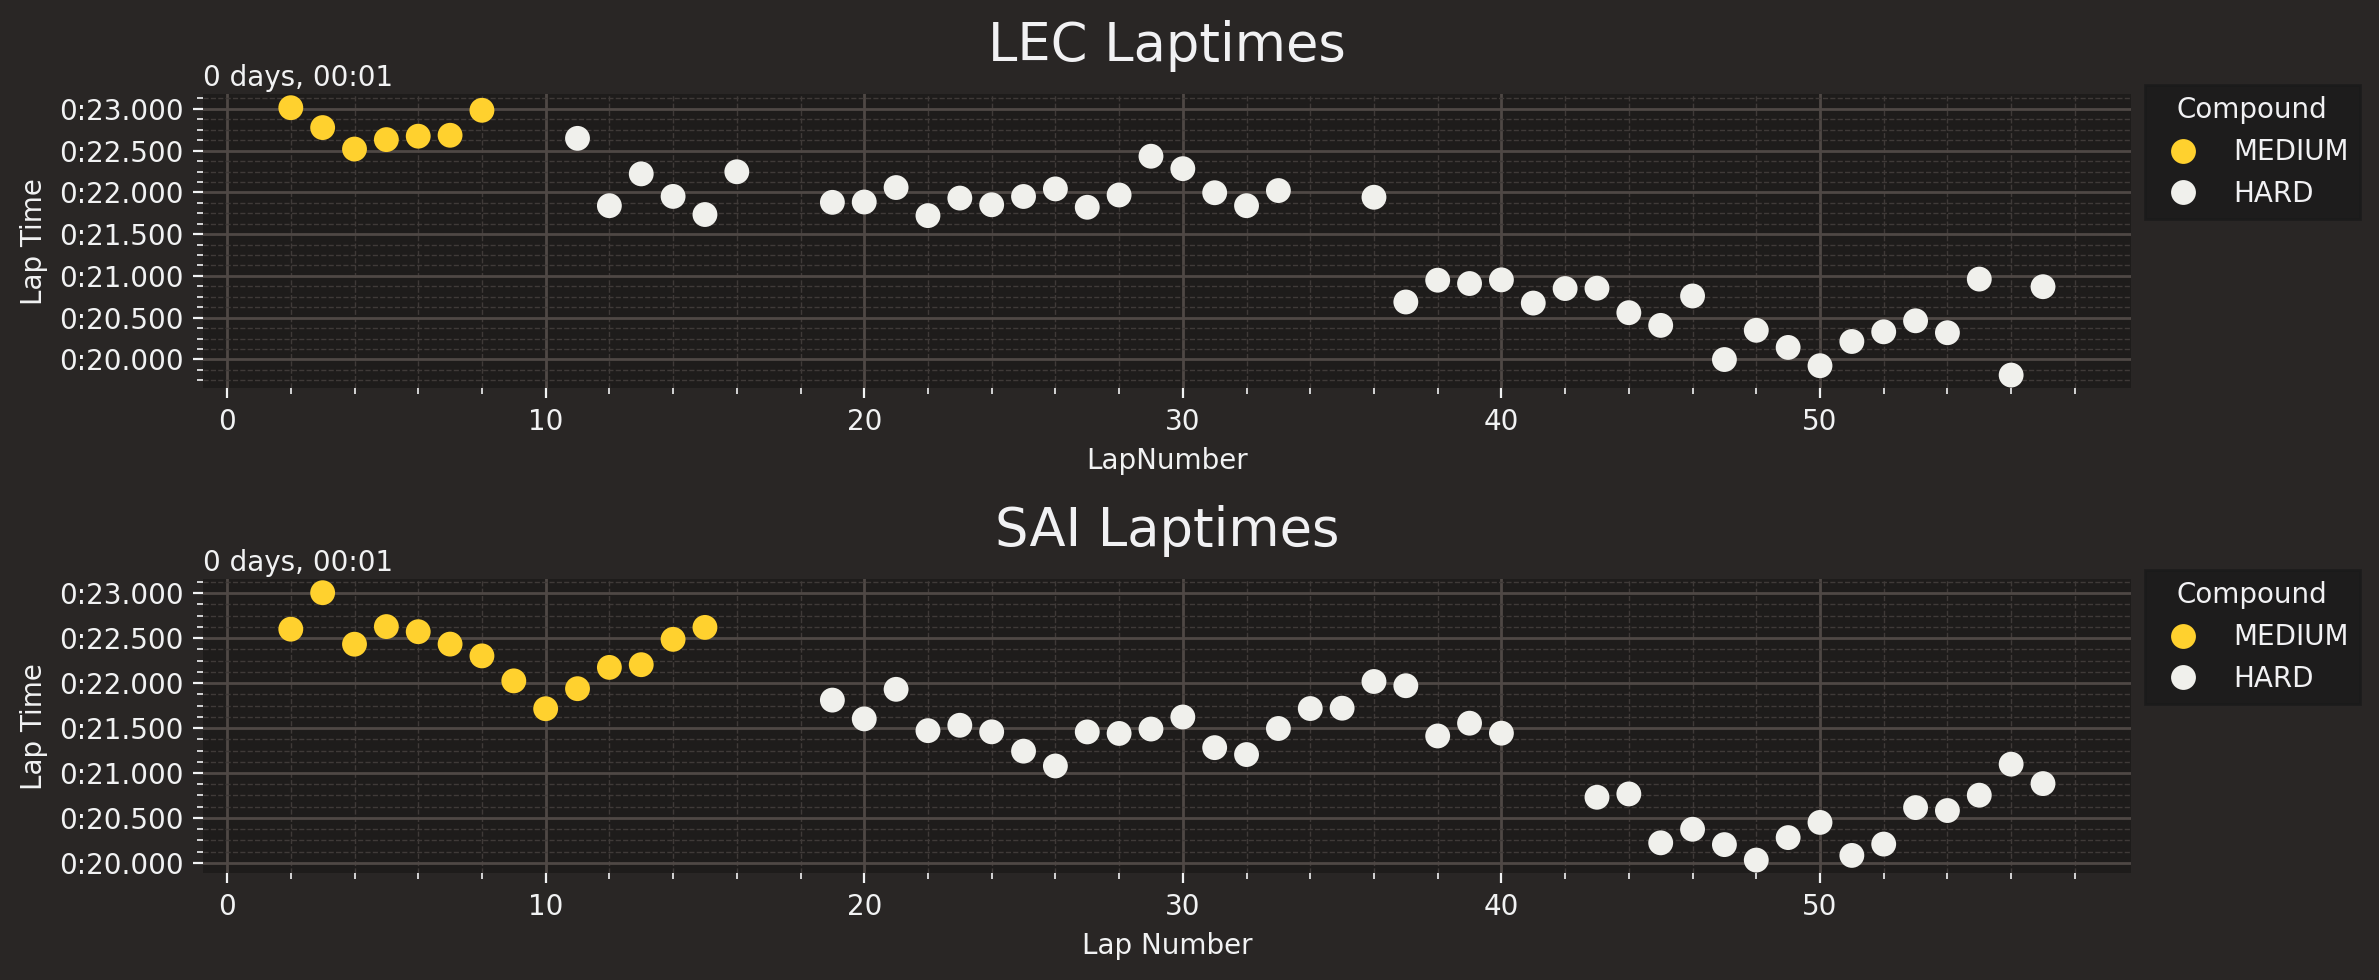

In [198]:
plot_driver_laptimes(session, 'LEC', 'SAI')

In [276]:
lec_tel

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-03-24 05:19:11.424,10541,298,8,100,False,0,car,0 days 00:00:00.120000,0 days 02:14:28.226000,9.933333
1,2024-03-24 05:19:11.704,10695,300,8,100,False,0,car,0 days 00:00:00.400000,0 days 02:14:28.506000,33.266667
2,2024-03-24 05:19:12.144,10749,302,8,100,False,0,car,0 days 00:00:00.840000,0 days 02:14:28.946000,70.177778
3,2024-03-24 05:19:12.344,10762,304,8,100,False,0,car,0 days 00:00:01.040000,0 days 02:14:29.146000,87.066667
4,2024-03-24 05:19:12.504,10762,304,8,100,False,0,car,0 days 00:00:01.200000,0 days 02:14:29.306000,100.577778
...,...,...,...,...,...,...,...,...,...,...,...
284,2024-03-24 05:20:29.984,11588,289,7,100,False,0,car,0 days 00:01:18.680000,0 days 02:15:46.786000,5130.160278
285,2024-03-24 05:20:30.184,11635,292,7,100,False,0,car,0 days 00:01:18.880000,0 days 02:15:46.986000,5146.382500
286,2024-03-24 05:20:30.504,11292,294,7,100,False,0,car,0 days 00:01:19.200000,0 days 02:15:47.306000,5172.515833
287,2024-03-24 05:20:30.864,10603,294,8,100,False,0,car,0 days 00:01:19.560000,0 days 02:15:47.666000,5201.915833


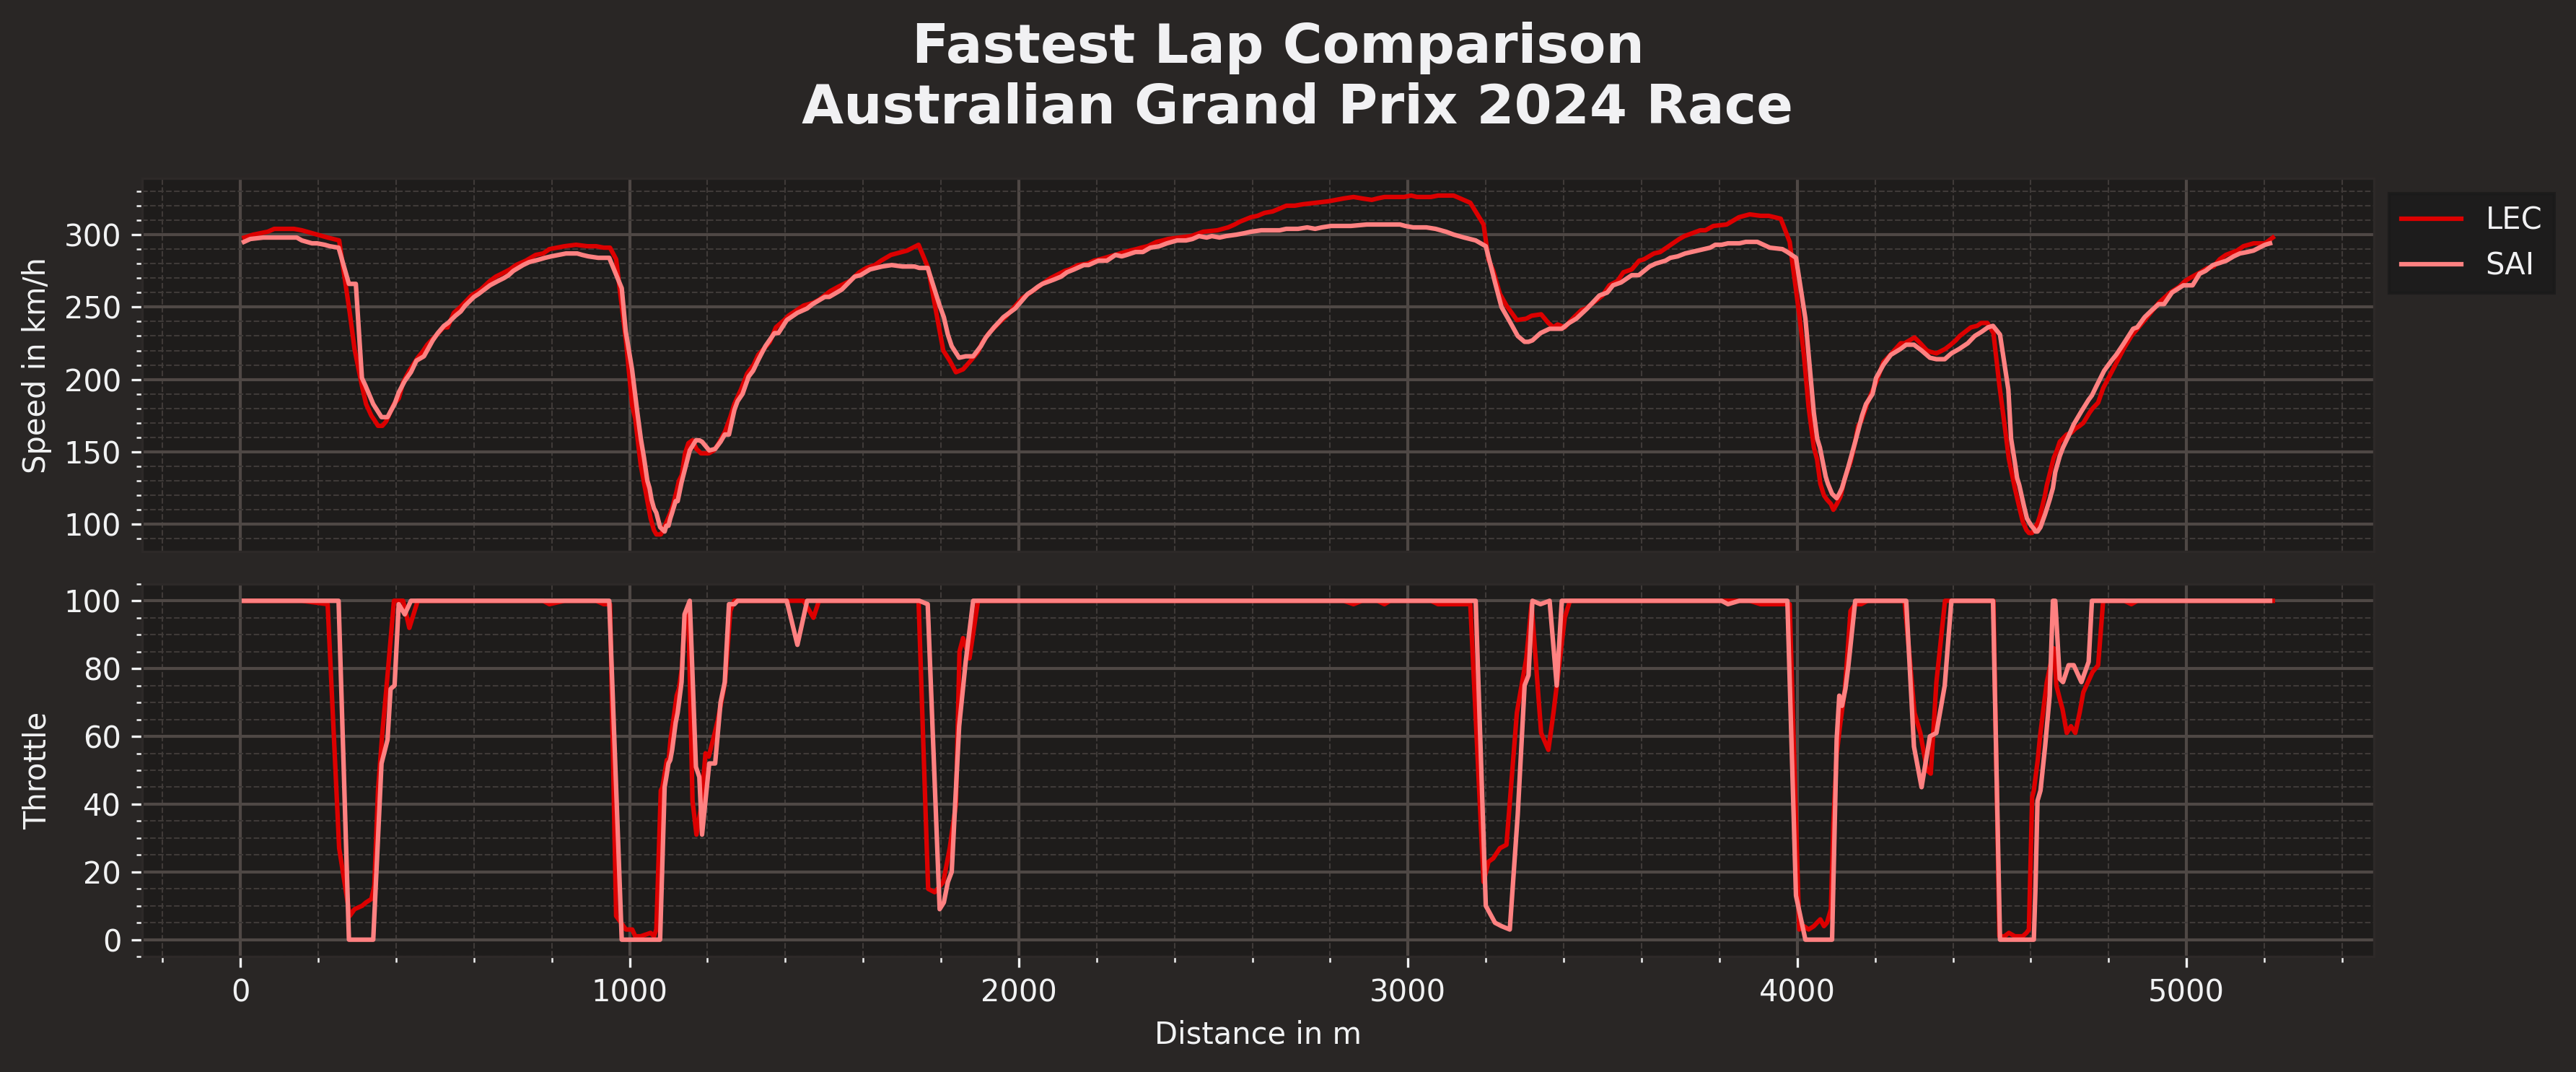

In [295]:
lec_col = ff1.plotting.driver_color('LEC')
sai_col = ff1.plotting.driver_color('SAI')

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,5), dpi = 300)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color=lec_col, label='LEC')
ax1.plot(sai_tel['Distance'], sai_tel['Speed'], color=sai_col, label='SAI')

ax1.tick_params(
    axis='x',          
    which='both',     
    bottom=False,      
    top=False,        
    labelbottom=False)


ax2.plot(lec_tel['Distance'], lec_tel['Throttle'],color = lec_col)
ax2.plot(sai_tel['Distance'], sai_tel['Throttle'],color = sai_col)

ax1.set_ylabel('Speed in km/h')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.set_xlabel('Distance in m')
ax2.set_ylabel('Throttle')

plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Race", fontsize = 18, fontweight = 'bold')
plt.tight_layout()
plt.show()

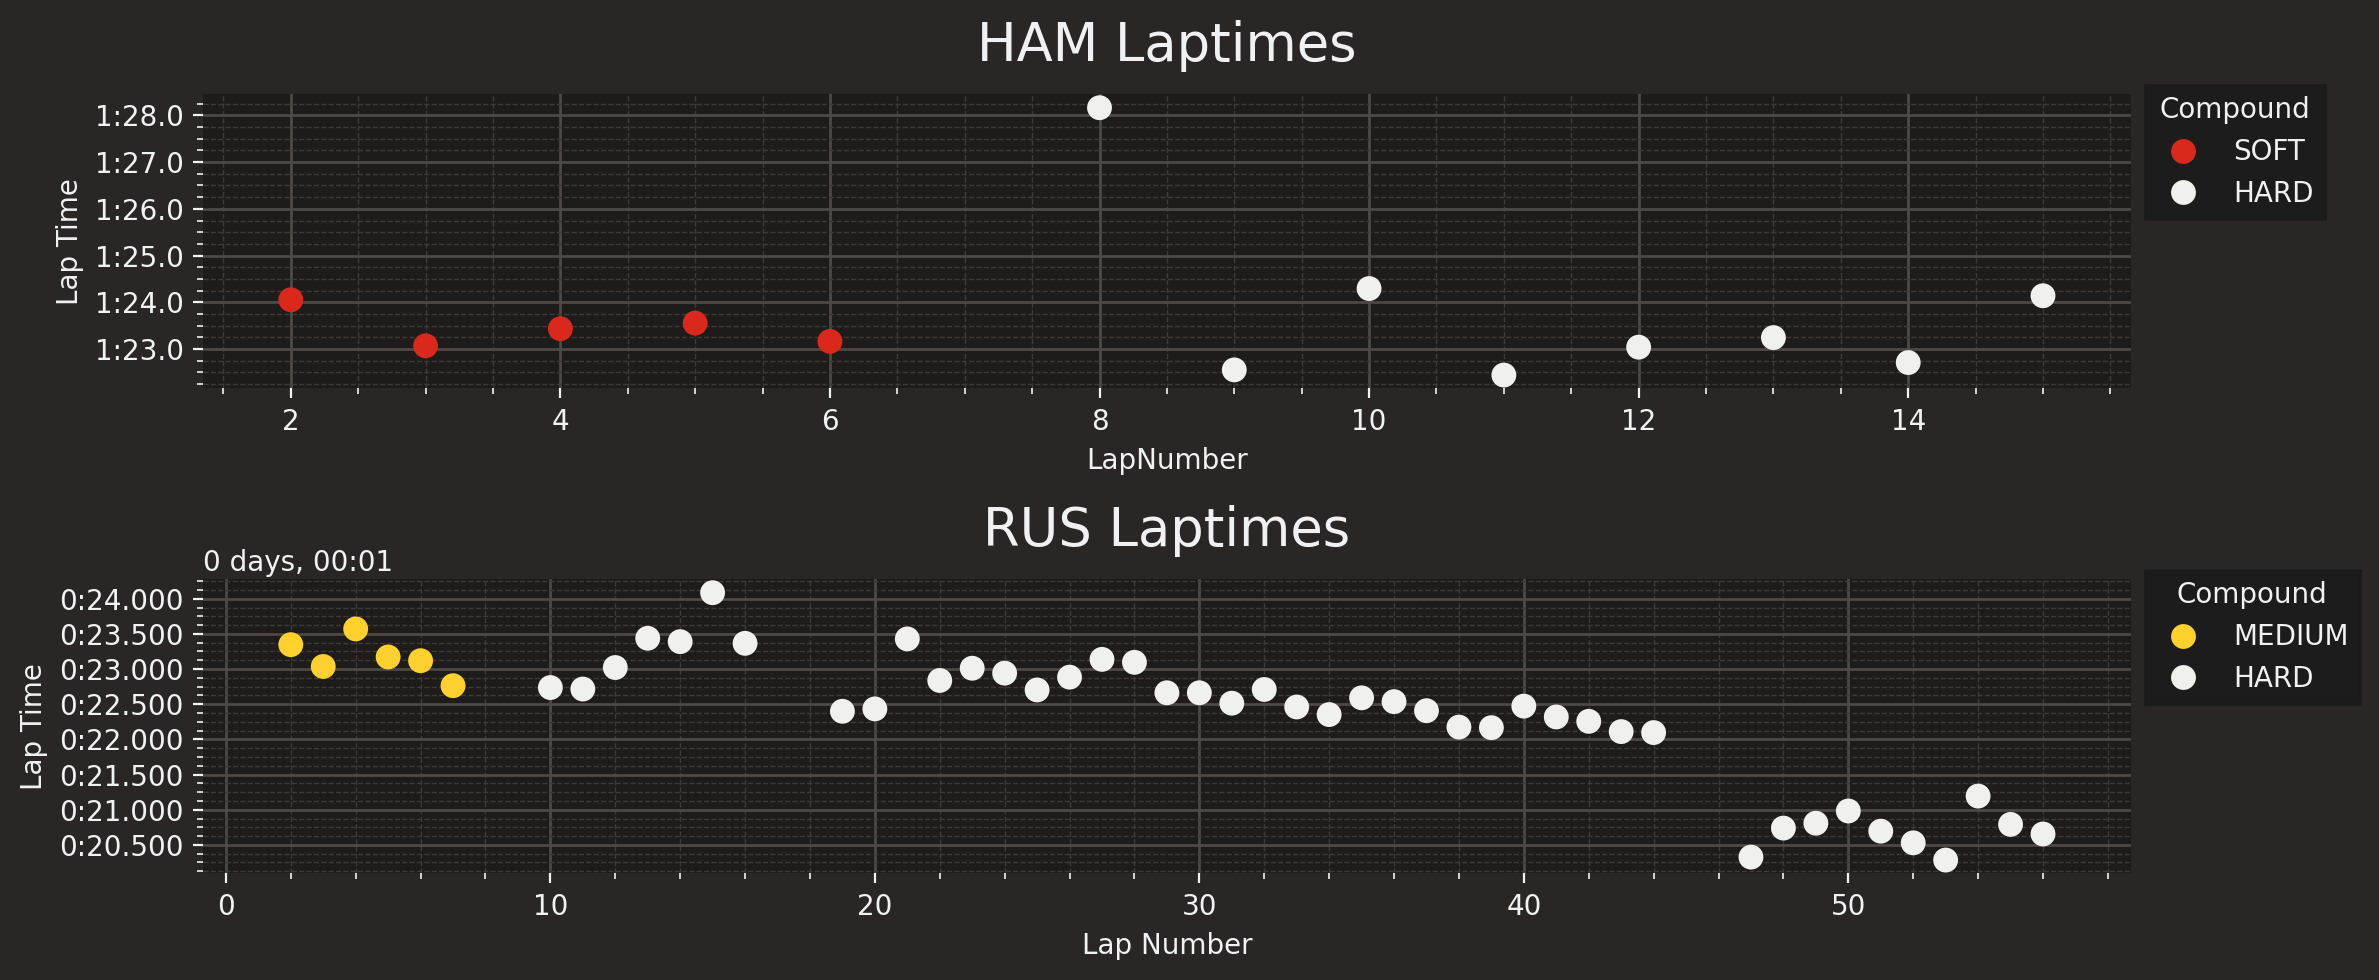

In [199]:
plot_driver_laptimes(session, 'HAM', 'RUS')

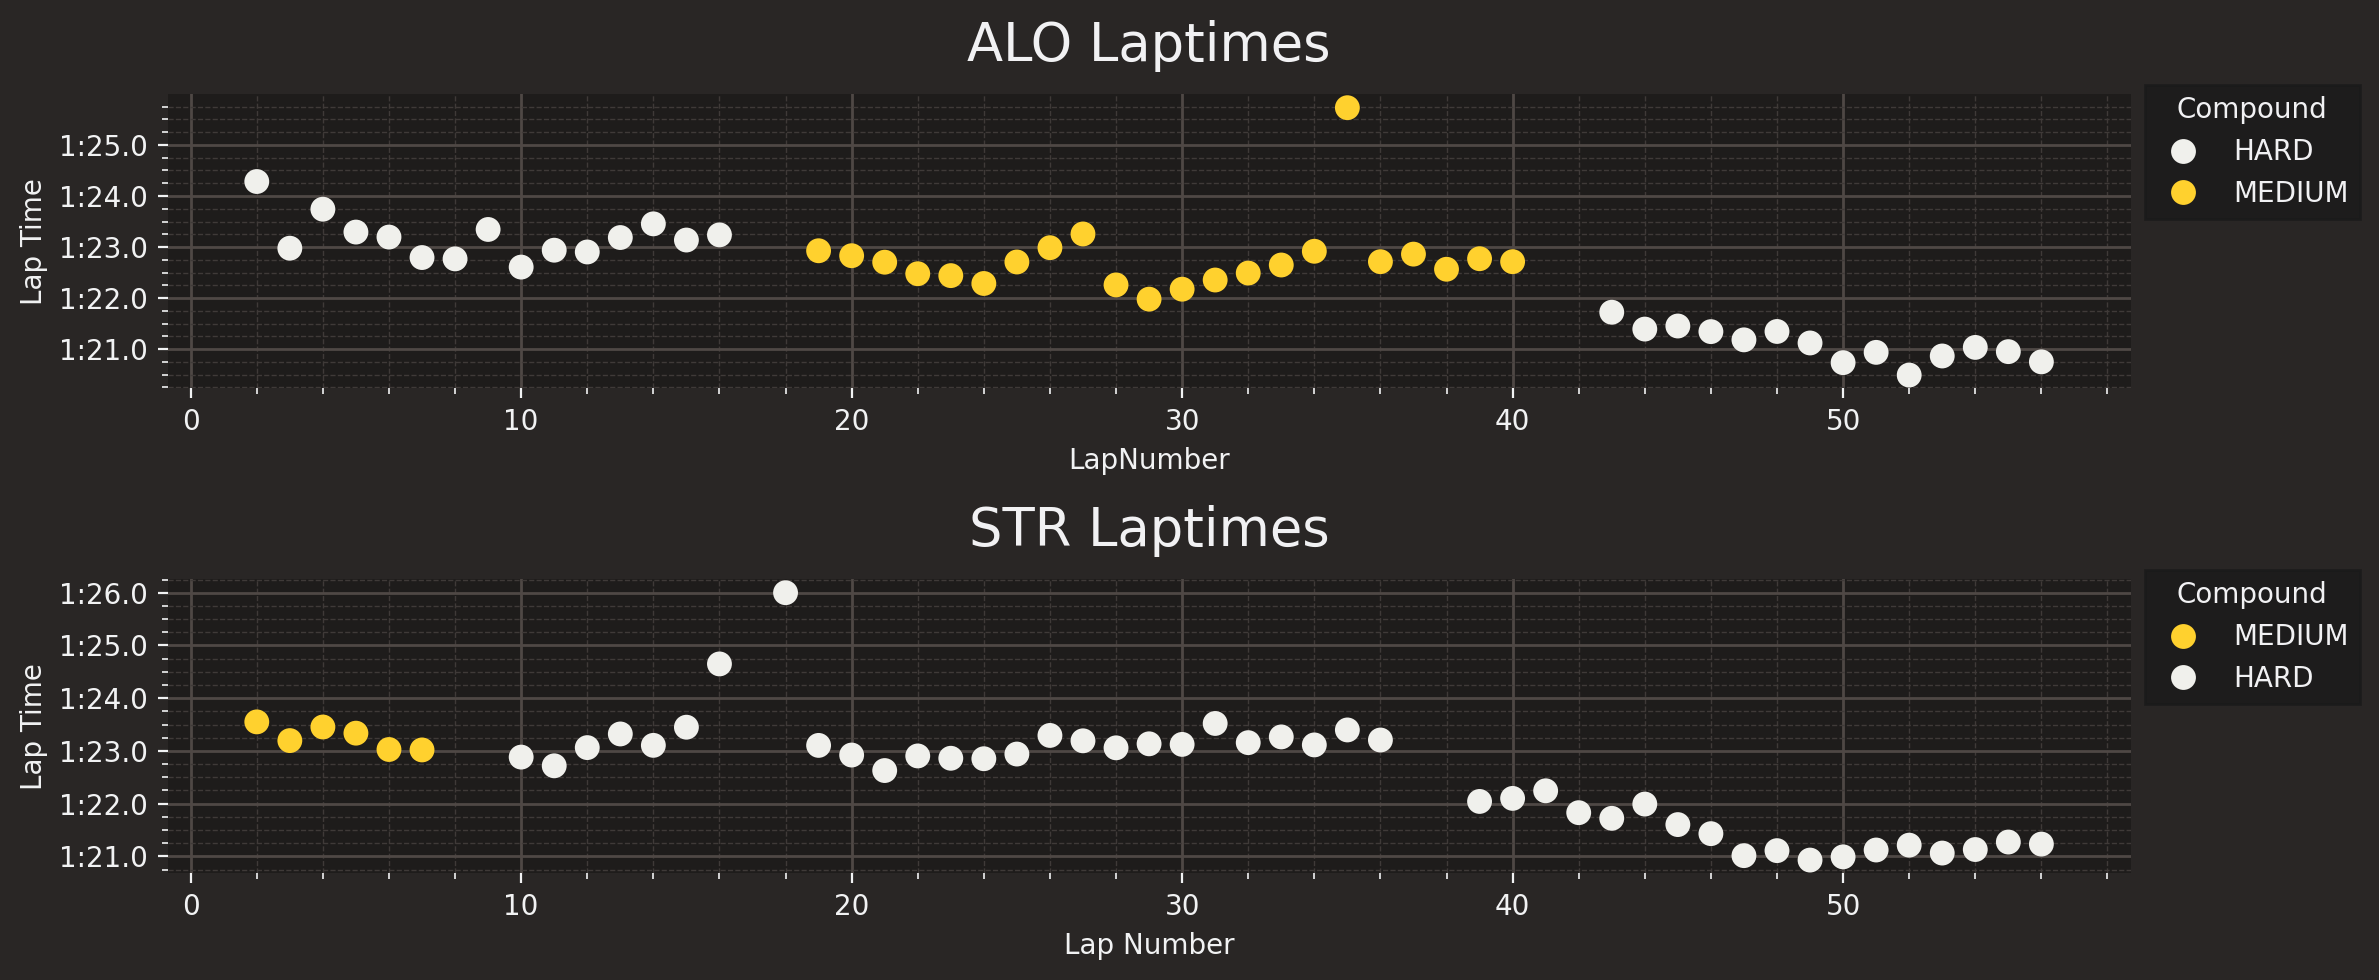

In [209]:
plot_driver_laptimes(session, 'ALO', 'STR')

# Lap Time Distribution 

In [222]:
point_finishers = session.drivers[:10]
print(point_finishers)

driver_laps = session.laps.pick_drivers(point_finishers).pick_quicklaps()
driver_laps = driver_laps.reset_index()
finishing_order = [session.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
print(driver_colors)

['55', '16', '4', '81', '11', '18', '22', '14', '27', '20']
['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'STR', 'TSU', 'ALO', 'HUL', 'MAG']
{'LEC': '#dc0000', 'SAI': '#ff8181', 'SHW': '#9c0000', 'VER': '#fcd700', 'PER': '#ffec7b', 'DEN': '#907400', 'PIA': '#ff8700', 'NOR': '#eeb370', 'OWA': '#ee6d3a', 'GAS': '#fe86bc', 'OCO': '#ff117c', 'DOO': '#894667', 'BOT': '#00e701', 'ZHO': '#008d01', 'POU': '#004601', 'DEV': '#1e3d61', 'TSU': '#356cac', 'RIC': '#2b4562', 'LAW': '#2b4562', 'HAD': '#1e6176', 'MAG': '#ffffff', 'HUL': '#cacaca', 'BEA': '#c40000', 'ALO': '#006f62', 'STR': '#00413b', 'DRU': '#2f9b90', 'HAM': '#00d2be', 'RUS': '#24ffff', 'VES': '#00a6ff', 'ALB': '#005aff', 'SAR': '#012564', 'OSU': '#1b3d97'}


In [241]:
my_compound = {'SOFT': '#da291c',
 'MEDIUM': '#ffd12e',
 'HARD': '#0a0a0a',
 'INTERMEDIATE': '#43b02a',
 'WET': '#0067ad',
 'UNKNOWN': '#00ffff',
 'TEST-UNKNOWN': '#434649'}

In [244]:
from matplotlib.patches import Patch

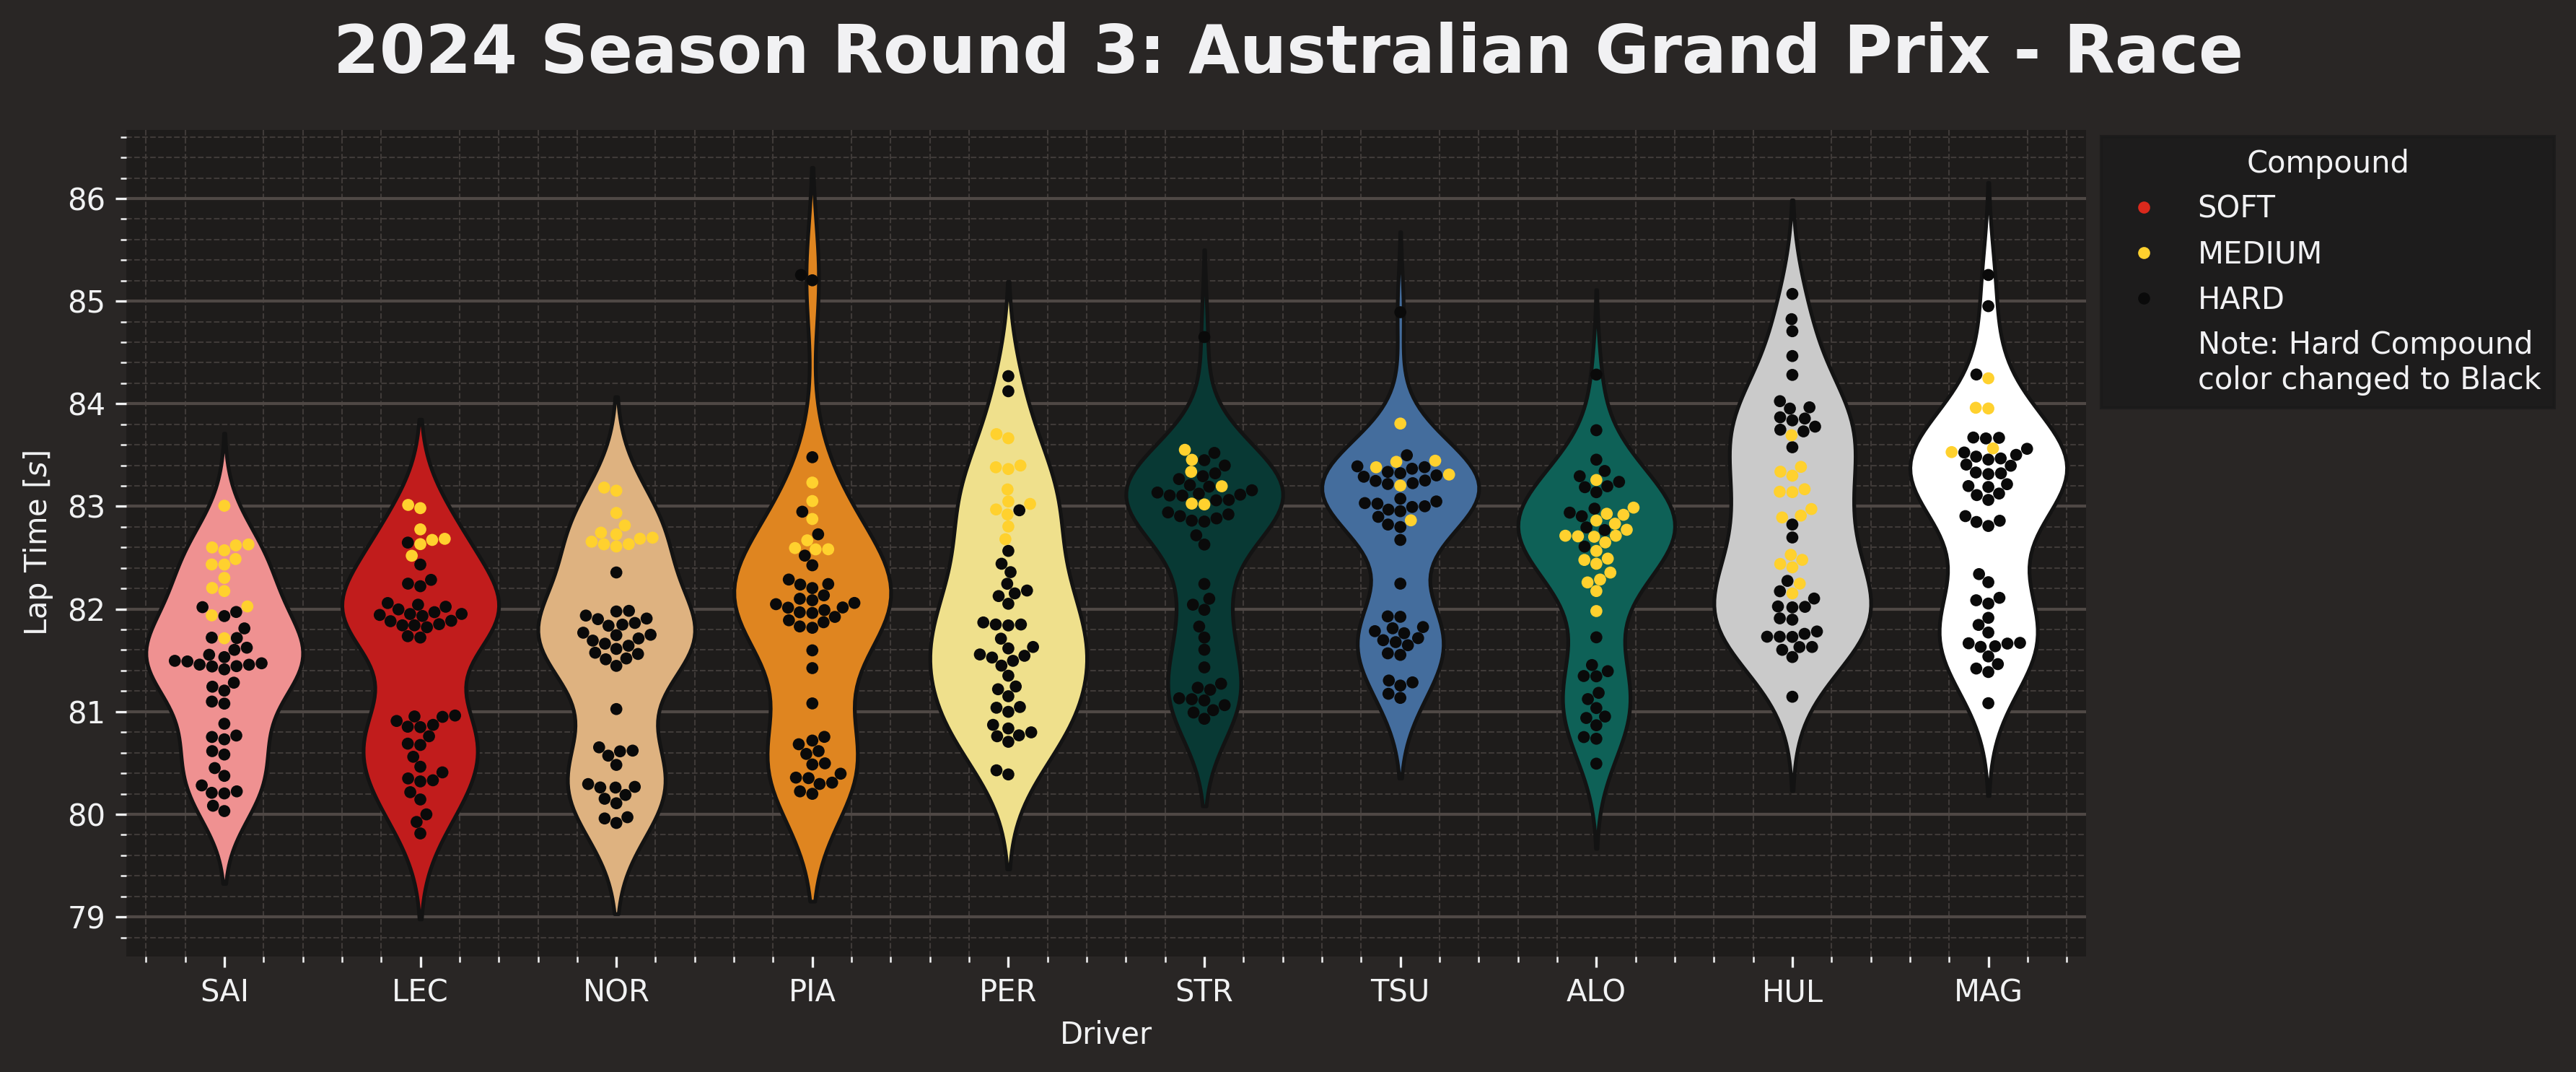

In [258]:
fig, ax = plt.subplots(figsize=(12, 5), dpi = 300)

driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=finishing_order,
               palette=driver_colors
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=my_compound,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              size=4,
              )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time $[s]$")

# plot the legend outside the plot 
handles, labels = ax.get_legend_handles_labels()

# Note
note_handle = Patch(color='none')
handles.append(note_handle)
labels.append('Note: Hard Compound \ncolor changed to Black')


ax.legend(handles=handles, labels=labels, title="Compound", loc="upper left", bbox_to_anchor=(1, 1.01))

plt.suptitle(session, fontsize = 22, fontweight = 'bold')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()